In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
print('Setup done')

Setup done


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/sar.csv', sep=',')
df_client_rfm = pd.read_csv('/content/gdrive/MyDrive/client_rfm.csv', sep=',')
print("dataset Loaded")

dataset Loaded


In [ ]:
df_client_rfm = df_client_rfm[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']]

In [ ]:
df['ProductId'].nunique()

54708

In [ ]:
df_client_product = df[['Client','ProductId','Rating']].copy()
df_client_product = pd.merge(df_client_product,df_client_rfm,on='Client',how='left')

df_client_product.drop_duplicates(keep='first',inplace=True,subset=['Client','ProductId']) 


n_users = df_client_product['Client'].nunique()
n_users

10816

In [ ]:
df_product = df[['ProductId','Product','Product Category','Product Cost']].copy()
df_product.drop_duplicates(keep='first',inplace=True) 

n_prod = df_product['ProductId'].nunique()
n_prod

54708

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

prod_enc = LabelEncoder()
df_client_product['Client'] = prod_enc.fit_transform(df_client_product['Client'].values)

prod_enc = LabelEncoder()
df_product['Product'] = prod_enc.fit_transform(df_product['Product'].values)

prod_cat_enc = LabelEncoder()
df_product['Product Category'] = prod_cat_enc.fit_transform(df_product['Product Category'].values)

prod_id_enc = LabelEncoder()
df_product['ProductId'] = prod_id_enc.fit_transform(df_product['ProductId'].values)
df_client_product['ProductId'] = prod_id_enc.transform(df_client_product['ProductId'].values)

In [ ]:
train, test = train_test_split(df_client_product, test_size=0.2, random_state=42)

In [ ]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model

product_input = Input(shape=[1], name="Product-Input")

product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Product")(product_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
# concatted = Concatenate()([product_vec, user_vec])
# d = Dense(4, kernel_initializer='normal')(concatted)
# out = Dense(1, kernel_initializer='normal')(d)
model = Model([user_input, product_input], prod)
model.compile('adam', 'mean_squared_error')

In [ ]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model

product_input = Input(shape=[1], name="Product-Input")

product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Product")(product_embedding)

user_input = Input(shape=[5], name="User-Input")
user_embedding = Embedding(n_users+1, 8, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
concatted = Concatenate()([product_vec, user_vec])
d = Dense(4, kernel_initializer='normal')(concatted)
out = Dense(1, kernel_initializer='normal')(d)
model_rfm = Model([user_input, product_input], out)
model_rfm.compile('adam', 'mean_squared_error')

In [ ]:
df_client_product

,Client,ProductId,Rating,Rank_Recency,Rank_Frequency,Rank_Monetary,Cluster
0,763,18402,7.5,1736,2000,2000,4
32,8310,17466,7.5,1170,2000,2000,4
64,697,14033,6.5,2001,2000,2000,4
96,763,23790,7.5,1736,2000,2000,4
128,763,16787,7.5,1736,2000,2000,4
...,...,...,...,...,...,...,...
1628892,2233,9840,4.5,1346,1562,1471,4
1628917,5848,9904,6.0,1515,1762,1802,4
1628918,6270,3711,6.0,1824,1940,1905,4
1628920,519,40335,5.0,1535,1426,1139,4


In [ ]:
history = model.fit([train[['Client']],
                     train[['ProductId']]], train['Rating'],
                    validation_data=
                    ([test[['Client']],
                      test['ProductId']], test['Rating']), epochs=2, verbose=1)
model.save('regression_model.h5')

Epoch 1/2
12577/12577 [==============================] - 59s 5ms/step - loss: 22.8093 - val_loss: 17.5823
Epoch 2/2
12577/12577 [==============================] - 57s 5ms/step - loss: 14.0965 - val_loss: 7.7261


In [ ]:
history_rfm = model_rfm.fit([train[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']],
                             train[['ProductId']]], train['Rating'],
                            validation_data=([test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']],
                                              test['ProductId']], test['Rating']), epochs=2, verbose=1)
model_rfm.save('regression_model.h5')

Epoch 1/2
12577/12577 [==============================] - 62s 5ms/step - loss: 2.3175 - val_loss: 0.5006
Epoch 2/2
12577/12577 [==============================] - 60s 5ms/step - loss: 0.4217 - val_loss: 0.4626


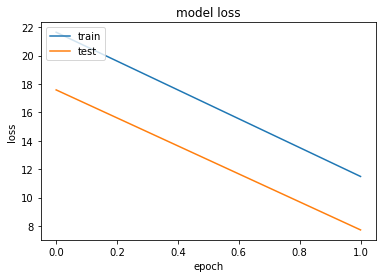

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
test['ProductId'].values
product_db = np.array(list(set(test['ProductId'])))

In [ ]:
# Creating dataset for making recommendations for the first user
# Without RFM

product_db = np.array(list(set(train['ProductId'])))

user = test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
user = np.array([1 for i in range(len(product_db))])

predictions = model.predict([user, product_db])

predictions = np.array([a[0] for a in predictions])

# recommended_book_ids = (-predictions).argsort()[:5]
# print(recommended_book_ids)
# print(predictions[recommended_book_ids])

In [ ]:
max(predictions)

4.721917

In [ ]:
# Creating dataset for making recommendations for the first user
# With RFM

product_db = np.array(list(set(df_client_product['ProductId'])))

user = test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1].values
user_t = np.array([user for i in range(len(product_db))])

predictions = model_rfm.predict([user_t, product_db])

predictions = np.array([a[0] for a in predictions])

# recommended_book_ids = (-predictions).argsort()[:5]
# print(recommended_book_ids)
# print(predictions[recommended_book_ids])

In [ ]:
user

array([6562, 1743, 1506, 1887,    4])

In [ ]:
max(predictions)

6.831622